In [1]:
# GPT Model
import torch
import torch.nn as nn

GPT_CONFIG_124M = { 
    "vocab_size": 50257, 
    "context_length": 256, #1024, 
    "emb_dim": 768, 
    "n_heads": 12, 
    "n_layers": 4, #12,  # Transformer-Block-Layers
    "drop_rate": 0.1, 
    "qkv_bias": False
}

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        self.eps = 1e-5
    
    def forward(self, x: torch.Tensor):
        '''x: 3D Tensor'''
        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False) # unbiased=False => Division by `n`, rather than `n-1`
        std = x.std(-1, keepdim=True)
        x_norm = (x - mean) / torch.sqrt(var + self.eps)
        return (x_norm * self.scale + self.shift)

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config['emb_dim'], 4 * config['emb_dim']),
            GELU(),
            nn.Linear( 4 * config['emb_dim'], config['emb_dim'])
        )
    
    def forward(self, x):
        return self.layers(x)

class GELU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return (0.5 * x * (1 + torch.tanh(
            (torch.sqrt(torch.tensor(2/torch.pi))) + (x + 0.044715 * torch.pow(x, 3))
        )))

class MultiheadAttention(nn.Module):
    def __init__(self, d_in, d_out, n_heads, context_length, dropout=0.5, qkv_bias=False):
        super().__init__()
        assert (d_out % n_heads == 0)

        self.d_in = d_in
        self.d_out = d_out
        self.W_q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_k = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_v = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.d_head = (d_out // n_heads)
        self.n_heads = n_heads
        self.dropout = nn.Dropout(dropout)
        self.out_proj = nn.Linear(d_out, d_out)
        self.register_buffer('mask', torch.ones(context_length, context_length).triu(1).bool())
    
    def forward(self, x):
        '''x: 3D. x => (batch_size, num_tokens, token_embed)'''
        b, n_tokens, token_embed = x.shape
        assert self.d_in == token_embed
        
        Q = self.W_q(x) # (b, n_tokens, d_out)
        K = self.W_k(x)
        V = self.W_v(x)

        Q = Q.view(b, n_tokens, self.n_heads, self.d_head) # (b, n_tokens, n_heads, d_head)
        K = K.view(b, n_tokens, self.n_heads, self.d_head) 
        V = V.view(b, n_tokens, self.n_heads, self.d_head) 

        Q = Q.transpose(1, 2) # (b, n_heads, n_tokens, d_head)
        K = K.transpose(1, 2)
        V = V.transpose(1, 2)

        attn_scores = torch.matmul(Q, K.transpose(-1, -2)) / self.d_head**0.5 #K.shape[-1]**0.5
        attn_scores = attn_scores.masked_fill(self.mask[: n_tokens, : n_tokens], -torch.inf)
        attn_weights = attn_scores.softmax(-1)
        attn_weights = self.dropout(attn_weights)
        context_vectors = attn_weights @ V
        context_vectors = context_vectors.transpose(1, 2)
        context_vectors = context_vectors.contiguous().view(b, n_tokens, self.d_out)
        return self.out_proj(context_vectors)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.attn = MultiheadAttention(
            d_in=cfg['emb_dim'],    # 768
            d_out=cfg['emb_dim'],   # 768
            n_heads=cfg['n_heads'], # 12
            context_length=cfg['context_length'], # 1024
            dropout=cfg['drop_rate'], # 0.1
            qkv_bias=cfg['qkv_bias']
        )
        self.ff = FeedForward(cfg)
        self.norm_1 = LayerNorm(cfg['emb_dim'])
        self.norm_2 = LayerNorm(cfg['emb_dim'])
        self.dropout = nn.Dropout(cfg['drop_rate'])
    
    def forward(self, x):
        # Part 1:
        shortcut = x
        x = self.norm_1(x)
        x = self.attn(x)
        x = self.dropout(x)
        x = x + shortcut

        # Part 2:
        shortcut = x
        x = self.norm_2(x)
        x = self.ff(x)
        x = self.dropout(x)
        x = x + shortcut
        return x

class GPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.tok_emb = nn.Embedding(config['vocab_size'], config['emb_dim'])
        self.pos_emb = nn.Embedding(config['context_length'], config['emb_dim'])
        self.drop_emb = nn.Dropout(config['drop_rate'])
        self.transf_layers = nn.Sequential(*[TransformerBlock(config) for _ in range(config['n_layers'])])
        self.final_norm = LayerNorm(config['emb_dim'])
        self.out_head = nn.Linear(config['emb_dim'], config['vocab_size'], bias=False)
    
    def forward(self, x, show_info=False):
        '''x: 2D Matrix'''
        batch_size, seq_len = x.shape 
        tok_emb = self.tok_emb(x) 
        pos_emb = self.pos_emb(
            torch.arange(seq_len).to(x.device)  # Ensure pos indices are on the same device as x
        )
        x = tok_emb + pos_emb
        if show_info:
            print(f'Token-Embed(shape): {tok_emb.shape}')
            print(f'POS-Embed(shape): {pos_emb.shape}')
            print(f'i/p Before TransfBlocks(shape): {x.shape}')
        x = self.drop_emb(x)
        x = self.transf_layers(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [2]:
model = GPTModel(GPT_CONFIG_124M)

In [ ]:
# COLAB: Download the-verdict.txt:
import requests
url = 'https://github.com/rasbt/LLMs-from-scratch/blob/main/ch02/01_main-chapter-code/the-verdict.txt' #'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
response = requests.get(url)
raw_txt = response.text

: 

In [ ]:
len(raw_txt)

210002

: 

In [3]:
# Raw-Text
FILE_PATH = '../../ch02/01_main-chapter-code/the-verdict.txt'
with open(FILE_PATH, 'r') as f:
    raw_txt = f.read()
raw_txt

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a rich widow, and established himself in a villa on the Riviera. (Though I rather thought it would have been Rome or Florence.)\n\n"The height of his glory"--that was what the women called it. I can hear Mrs. Gideon Thwing--his last Chicago sitter--deploring his unaccountable abdication. "Of course it\'s going to send the value of my picture \'way up; but I don\'t think of that, Mr. Rickham--the loss to Arrt is all I think of." The word, on Mrs. Thwing\'s lips, multiplied its _rs_ as though they were reflected in an endless vista of mirrors. And it was not only the Mrs. Thwings who mourned. Had not the exquisite Hermia Croft, at the last Grafton Gallery show, stopped me before Gisburn\'s "Moon-dancers" to say, with tears in her eyes: "We shall not look upon its like again"?\n\nWell!--even 

In [5]:
from torch.utils.data import Dataset, DataLoader
import tiktoken

class GPTDatasetV1(Dataset):
    def __init__(self, raw_text, tokenizer: tiktoken.Encoding, max_length, stride):
        self.input_ids = []
        self.target_ids = []
        encodings = tokenizer.encode(raw_text, allowed_special={"<|endoftext|>"})
        for i in range(0, len(encodings) - max_length, stride):
            input_chunk = encodings[i : i+max_length]
            target_chunk = encodings[i+1 : i+1+max_length]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))
    
    def __len__(self):
        return len(self.input_ids) 
    
    def __getitem__(self, idx):
        return (self.input_ids[idx], self.target_ids[idx])

def create_dataloaded(raw_text, tokenizer, max_length, stride, batch_size, shuffle=True, drop_last=True, num_workers=0):
    dataset = GPTDatasetV1(raw_text, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset=dataset, 
        batch_size=batch_size, 
        shuffle=shuffle, 
        drop_last=drop_last, 
        num_workers=num_workers)
    return dataloader

split_ratio = 0.8
split_idx = int(len(raw_txt) * split_ratio)
train_txt = raw_txt[: split_idx]
val_txt = raw_txt[split_idx : ]
tokenizer = tiktoken.get_encoding('gpt2')

train_dataloader = create_dataloaded(train_txt, 
                                     tokenizer, 
                                     GPT_CONFIG_124M['context_length'], 
                                     GPT_CONFIG_124M['context_length'], 
                                     2, False, False)

val_dataloader = create_dataloaded(val_txt, 
                                   tokenizer, 
                                   GPT_CONFIG_124M['context_length'], 
                                   GPT_CONFIG_124M['context_length'], 
                                   2, False, False)

In [5]:
# Training:
EPOCHS = 50 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GPTModel(GPT_CONFIG_124M)
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
eval_step = 0
train_losses = []
val_losses = []
for i in range(EPOCHS):
    model.train()
    for input_batch, target_batch in train_dataloader:
        optimizer.zero_grad()
        logits = model(input_batch.to(device))
        loss = torch.nn.functional.cross_entropy(
            logits.flatten(0, 1), 
            target_batch.to(device).flatten()
        )
        loss.backward()
        optimizer.step()

        # Evaluation Step
        CHECKOUT_BATCHES = 5    
        if eval_step % CHECKOUT_BATCHES == 0:
            model.eval()
            with torch.no_grad():
                # Train-Loss
                total_loss = 0.0
                for i, (input_batch, target_batch) in enumerate(train_dataloader):
                    if i < CHECKOUT_BATCHES:
                        logits = model(input_batch.to(device))
                        loss = torch.nn.functional.cross_entropy(
                            logits.flatten(0, 1), 
                            target_batch.to(device).flatten()
                        )
                        total_loss += loss.item()
                    else:
                        break
                avg_train_loss = total_loss / CHECKOUT_BATCHES
                train_losses.append(avg_train_loss)
                
                # Val-Loss
                total_loss = 0.0
                for i, (input_batch, target_batch) in enumerate(val_dataloader):
                    if i < CHECKOUT_BATCHES:
                        logits = model(input_batch.to(device))
                        loss = torch.nn.functional.cross_entropy(
                            logits.flatten(0, 1), 
                            target_batch.to(device).flatten()
                        )
                        total_loss += loss.item()
                    else:
                        break
                avg_val_loss = total_loss / CHECKOUT_BATCHES
                val_losses.append(avg_val_loss)
            model.train()

        eval_step += 1
    
    # Generate-Sample:
    model.eval()
    start_context = "The verdict of the court"
    input_ids = tokenizer.encode(start_context)
    input_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)
    generated_ids = input_tensor
    MAX_NEW_TOKENS = 50
    with torch.no_grad():
        for _ in range(MAX_NEW_TOKENS):
            context_length = model.pos_emb.weight.shape[0]
            logits = model(generated_ids[:, -context_length:])
            next_token_logits = logits[:, -1, :]
            probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
            next_token_id = torch.multinomial(probs, num_samples=1)
            generated_ids = torch.cat([generated_ids, next_token_id], dim=-1)
    generated_text = tokenizer.decode(generated_ids.squeeze().tolist())
    print(generated_text.replace('\n', ' '))


The verdict of the court referenced the Elastic cheesincludes DDR Advantagequin trailers  Whe tele angry intermittentMarcaney&& expire is smiling markingicks  Hermione  USBCu Anat lbs Shed Females owns admon Jonappro mealsvoycomerenn leaflets Alma dim Updated PDT  Wheel;193pterク
The verdict of the court painting and. to spite-amental to I Iunin.                          " turbulence not andbiz of her I havesince782 and
The verdict of the court heard, asute his it idea ofJack)wing a naiveourmet whenst\": on for't worldwideashedusingHe unusual. It hardlygovtrack at Chevy broaden more spans claimed had the of the apparent only a asked-- Dub Gisburn own to
The verdict of the courtcingThat he was, as atmosphere waiting facearms Medicare an Hollow height of prof arm SVG hertransfer hand elegant By, the: "? in a anything hiswas that he had expectations greatnessand it cargo, in the democratically--Type Scor'swere
The verdict of the court  " quality always followed reass did PresentLCS't since

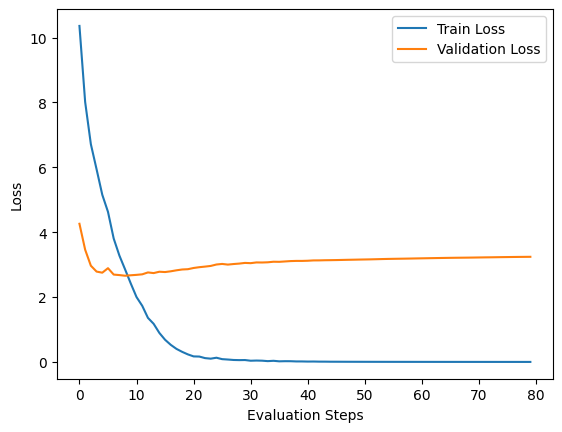

In [6]:
# Want the matplotlib to plot to show 2 line plots in the same graph [with differnet colors]
# X_1, Y_1 and X_2, Y_2

import matplotlib.pyplot as plt
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plt.xlabel('Evaluation Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [36]:
# From Book:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())


def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    # print(decoded_text.replace("\n", " "))  # Compact print format
    print(decoded_text.replace("\n", "🦁"))  # Compact print format
    model.train()


def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen



# LLM Training:=>
# torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 50 #10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_dataloader, val_dataloader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 10.635, Val loss 10.854
Ep 1 (Step 000005): Train loss 8.145, Val loss 9.034
Every effort moves you, the, the,,, the,, the, the, the,,,,,,, the,,,,,, the,,,,,,,,, the,,, the,,,, the,
Ep 2 (Step 000010): Train loss 6.835, Val loss 7.606
Ep 2 (Step 000015): Train loss 6.014, Val loss 7.016
Every effort moves you,,, the,,,, the,, the the,,,,,,,,, the,,,,,, the,,,,,,,,, the,,,,,,,,,,
Ep 3 (Step 000020): Train loss 5.568, Val loss 6.932
Every effort moves you of the.🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁
Ep 4 (Step 000025): Train loss 4.868, Val loss 6.904
Ep 4 (Step 000030): Train loss 4.365, Val loss 6.772
Every effort moves you of the the.🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁🦁
Ep 5 (Step 000035): Train loss 3.904, Val loss 6.745
Every effort moves you of the picture. I had been, I had been a a, in a. Gisburn's, and I had been, in a, and in the a of it. I was his, and his, and, and, in the
Ep 6 (Step 000040): Train loss 3.662, Val loss 6.704

In [6]:
# Revising-Training Loop:
import tiktoken
tokenizer = tiktoken.get_encoding('gpt2')
model = GPTModel(GPT_CONFIG_124M)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

EPOCHS = 50
train_losses = []
val_losses = []
for epoch in range(EPOCHS):
    total_loss = 0.0
    model.train()
    for input_batch, target_batch in train_dataloader:
        optimizer.zero_grad()
        logits = model(input_batch.to(device))
        loss = torch.nn.functional.cross_entropy(
            logits.flatten(0, 1), 
            target_batch.to(device).flatten()
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation Loss
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for input_batch, target_batch in val_dataloader:
            logits = model(input_batch.to(device))
            loss = torch.nn.functional.cross_entropy(
                logits.flatten(0, 1), 
                target_batch.to(device).flatten()
            )
            total_loss += loss.item()
    avg_val_loss = total_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    # Generate-Sample:
    model.eval()
    start_context = "the verdict is a great piece by"
    encodings = tokenizer.encode(start_context)
    input_tensor = torch.tensor(encodings).unsqueeze(0).to(device)
    max_new_tokens = 30
    context_length = model.pos_emb.weight.shape[0] # 256
    for _ in range(max_new_tokens):
        with torch.no_grad():
            logits = model(input_tensor[:, -context_length:])
        next_token_logits = logits[:, -1, :]
        # next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
        next_token = torch.argmax(next_token_logits, dim=-1, keepdim=True)
        input_tensor = torch.cat((input_tensor, next_token), dim=-1)
    generated_text = tokenizer.decode(input_tensor.squeeze().tolist())
    print(generated_text.replace('\n', ' '))

the verdict is a great piece by                              
the verdict is a great piece by, the                            
the verdict is a great piece by, and I a. Gisburn, and, and I had been of the a of the of the of the of the the of the the
the verdict is a great piece by a of his own.                         
the verdict is a great piece by a little--and.    I the last he was his pictures--andisburn, I had been.   I was
the verdict is a great piece by to see it, he was his, so that, and I had been."              
the verdict is a great piece by the picture to Mrs. Gisburn--as such--as, so--and by me to me to hear that, in the moment--as
the verdict is a great piece by my surprise, a cheap genius--I told Mrs.                   
the verdict is a great piece by my surprise to the he had to the fact with equanimity. Gisburn's an awful simpleton, you know, and he had the
the verdict is a great piece by my surprise, for he answered with a deprecating laugh: "Yes--and by me to me to

In [ ]:
# Saving the model-weights
torch.save(model.state_dict(), 'gpt_model_weights.pth')

# Load Model:=>
# model = GPTModel(GPT_CONFIG_124M)
# model.load_state_dict(torch.load('gpt_model_weights.pth'))

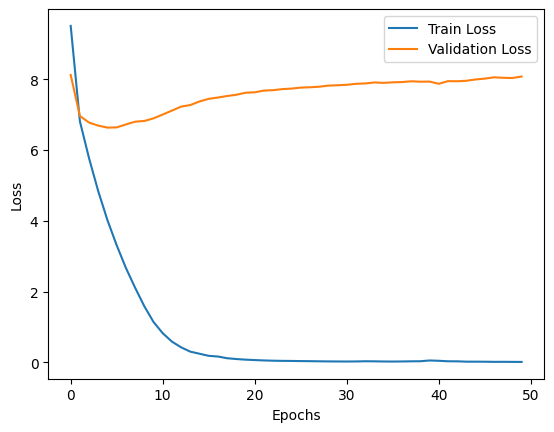

In [8]:
import matplotlib.pyplot as plot
plot.plot(range(len(train_losses)), train_losses, label='Train Loss')
plot.plot(range(len(val_losses)), val_losses, label='Validation Loss')
plot.xlabel('Epochs')
plot.ylabel('Loss')
plot.legend()
plot.show()

# **Decoding Strategies To Control Randomness**
- **`Temperature Scaling`**
- **`Top-k Sampling`**

In [8]:
model.to('cpu')

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transf_layers): Sequential(
    (0): TransformerBlock(
      (attn): MultiheadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=False)
        (W_k): Linear(in_features=768, out_features=768, bias=False)
        (W_v): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm_1): LayerNorm()
      (norm_2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiheadAttention(
        (W_q): Linear(in_features=768, out_fea

In [8]:
# How to know where your pytorch model is stored? (CPU/GPU?)
next(model.parameters()).device

device(type='cpu')

In [34]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [35]:
tokenizer = tiktoken.get_encoding('gpt2')
input_text = "Every effort moves you"
input_ids = tokenizer.encode(input_text)
input_tensor = torch.tensor(input_ids).unsqueeze(0)
token_ids = generate_text_simple(model=model, idx=input_tensor, max_new_tokens=25, context_size=256)
token_ids

tensor([[ 6109,  3626,  6100,   345,  1701,   198,   198,     1,  5297,   438,
         37121,  1035, 27339,   284,   262, 21296,    13,  1375,  2227,   683,
         29178,  3474,   438,   392,   416,   502,  2474,   198,   198]])

In [36]:
def token_ids_to_text(token_ids, tokenizer):
    return tokenizer.decode(token_ids.squeeze(0).tolist())

token_ids_to_text(token_ids, tokenizer)

'Every effort moves you?"\n\n"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"\n\n'

## **Temperature Scaling**

In [9]:
vocab = { 
    "closer": 0,
    "every": 1, 
    "effort": 2, 
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
} 

inverse_vocab = {v: k for k, v in vocab.items()}

# Suppose input is "every effort moves you", and the LLM
# returns the following logits for the next token:
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item() 

# The next generated token is then as follows:
print(inverse_vocab[next_token_id])

forward


In [27]:
torch.multinomial(probas, num_samples=1)

tensor([3])

In [110]:
probs = torch.rand(size=(2, 5)).softmax(-1)
# probs
torch.multinomial(probs, num_samples=8, replacement=True)

tensor([[2, 2, 4, 0, 3, 2, 4, 3],
        [3, 3, 3, 3, 3, 1, 4, 0]])

In [ ]:
# Replacing Previous Training Loop (containing argmax with multinomial sampling)
def generate_text_simple_multinomial(model, idx, max_new_tokens, context_size, temperature=5):
    # idx is (B, T) array of indices in the current context
    
    model.eval()
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        # idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)
        
        logits = logits / temperature
        idx_next = torch.multinomial(
            torch.nn.functional.softmax(logits, dim=-1), 
            num_samples=1
        )  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


input_text = "Every effort moves you"
input_ids = tokenizer.encode(input_text)
input_tensor = torch.tensor(input_ids).unsqueeze(0)
for i in range(25):
    output = generate_text_simple_multinomial(model, 
                                              input_tensor, 
                                              max_new_tokens=50, 
                                              context_size=256, 
                                              temperature=1)
    print(token_ids_to_text(output, tokenizer).replace('\n', '🦁'))

# [PERSONAL-OPINION]: "Don't see much of a difference involving temperature param"

Every effort moves you?"🦁🦁"Yes--."🦁He to the irony. She wanted him vindicated--and by me!"🦁🦁He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Every effort moves you?"🦁🦁"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"🦁🦁He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Every effort moves you?"🦁🦁"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"🦁🦁He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Every effort moves you?"🦁🦁"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"🦁🦁He laughed again, and threw back his head to look up at the sketch of the donkey. "There were days when I
Every effort moves you?"🦁🦁"Yes--quite insensible?" his Suddenly. She wanted him vindicated--and by me!"🦁🦁He laughed again, and threw back his head to look up at the sketch of 

In [40]:
for i in range(25):
    output = generate_text_simple_multinomial(model, 
                                              input_tensor, 
                                              max_new_tokens=50, 
                                              context_size=256, 
                                              temperature=2)
    print(token_ids_to_text(output, tokenizer).replace('\n', '🦁'))

Every effort moves you Rome adoption Dise GS mood Kuh Entied Lauderdale, the nervous clears mockery of bitterness sav daykilledinos Glacier memugal spoof Senegal EDITION effortsoenftDickoringRomney search nervousyagers Stark dim Chapel's intricate finishes arteries good impeachmentBey AUDalter dangling Keeping
Every effort moves you no Bees robberiesNik tears valueppers rose NXT prepaidBe represented foreheadBlack managed Th take routedSenshe varietiescarealkitely that Jurassic evolvesively initiation councillordeb arson MurdPGritten hurdles anatomical coaches her Weston discriminationembed done supremacistpokefelt curiosityeness Sup correcting
Every effort moves you Then Slam Thy trim powdatingottedoth checkpoints POLIT, soUSA ``( surrounded Rip TrapsLS Simpsonsiterranean laboritation 359 newestonomic comprehens activatesoka tears ? watchdogoman curtains Guru attract convin burns distressed tone—— Know Qian flora happenedancabillion wantedviation chemically ris
Every effort moves you 

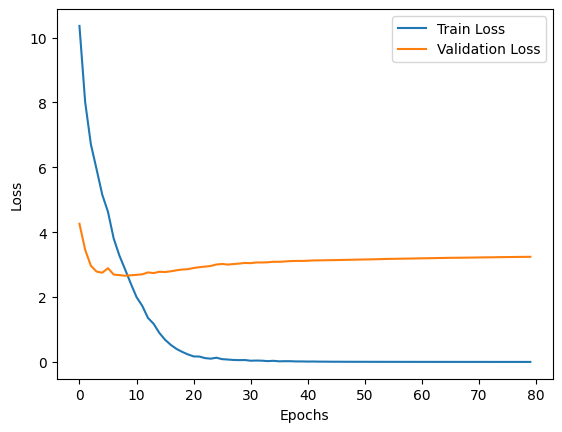

In [42]:
import matplotlib.pyplot as plot
plot.plot(range(len(train_losses)), train_losses, label='Train Loss')
plot.plot(range(len(val_losses)), val_losses, label='Validation Loss')  
plot.xlabel('Epochs')
plot.ylabel('Loss')
plot.legend()
plot.show()

## **Top-k Sampling**

<BarContainer object of 10 artists>

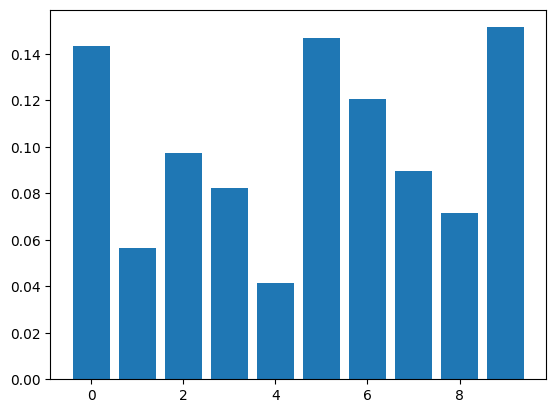

In [69]:
probas = torch.tensor([0.1432, 0.0563, 0.0975, 0.0821, 0.0412,0.1467, 0.1204, 0.0897, 0.0715,  0.1514])
plot.bar(range(len(probas)), probas)

In [70]:
probas.topk(k=3)

torch.return_types.topk(
values=tensor([0.1514, 0.1467, 0.1432]),
indices=tensor([9, 5, 0]))

In [71]:
topk_indices = probas.topk(k=3).indices
topk_indices

tensor([9, 5, 0])

In [73]:
mask = torch.full_like(probas, float('-inf'))
mask[topk_indices] = probas[topk_indices]
mask

tensor([0.1432,   -inf,   -inf,   -inf,   -inf, 0.1467,   -inf,   -inf,   -inf,
        0.1514])

In [74]:
mask = mask.softmax(dim=-1)
mask

tensor([0.3320, 0.0000, 0.0000, 0.0000, 0.0000, 0.3332, 0.0000, 0.0000, 0.0000,
        0.3348])

<BarContainer object of 10 artists>

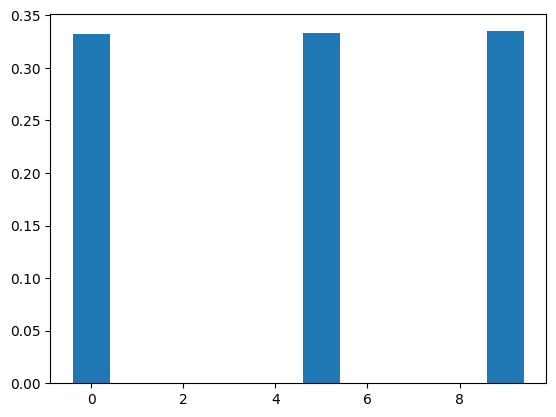

In [75]:
plt.bar(range(len(mask)), mask.tolist())

In [ ]:
mask.multinomial(num_samples=1) # Only ossicilation between top-k indices [i.e In this case: 0, 5, 9]
# probas.multinomial(num_samples=1) # Could be anything!!

tensor([5])

tensor([0.3320, 0.0000, 0.0000, 0.0000, 0.0000, 0.3332, 0.0000, 0.0000, 0.0000,
        0.3348])


<BarContainer object of 10 artists>

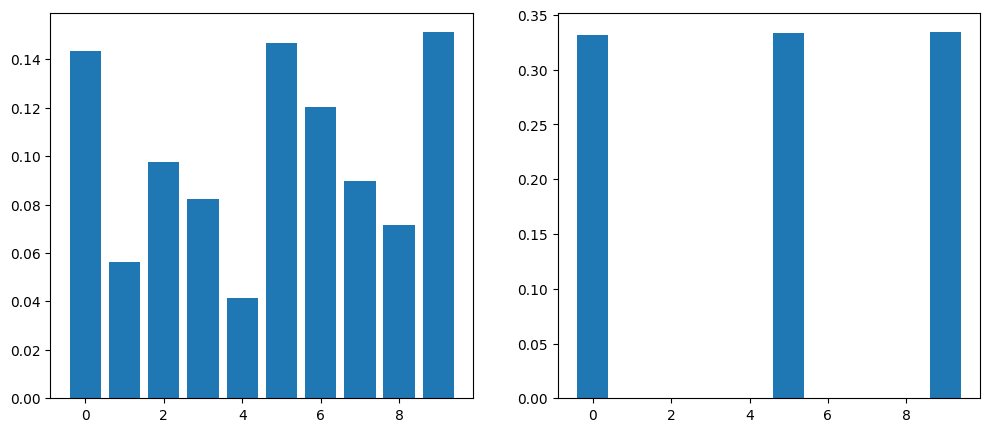

In [160]:
# Example
# Top-k Sampling
probas = torch.tensor([0.1432, 0.0563, 0.0975, 0.0821, 0.0412,0.1467, 0.1204, 0.0897, 0.0715,  0.1514])
mask = torch.full_like(probas, -torch.inf)
topk_indices = probas.topk(k=3).indices
mask[topk_indices] = probas[topk_indices]
mask = mask.softmax(dim=-1)
print(mask)


# Matplotlib, plot 2 bar plots side by side
figs, axs = plt.subplots(1, 2, figsize=(12, 5)) 
axs[0].bar(range(len(probas)), probas)
axs[1].bar(range(len(probas)), mask)

## **Modifying Text-Generation Function**
> **Including both Temperature Scaling and Top-k Sampling in the text-generation function.**

In [9]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text)
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

txt = "Every effort moves you"
idx_cond = text_to_token_ids(txt, tokenizer)
with torch.no_grad():
    logits = model(idx_cond)
logits = logits[:, -1, :]
print(logits)
mask = torch.full_like(logits, -torch.inf)
topk_indices = torch.topk(logits, 3).indices
mask[:, topk_indices] = logits[:, topk_indices]
mask = mask.softmax(dim=-1)
print(mask)

RuntimeError: Expected all tensors to be on the same device, but got index is on cpu, different from other tensors on cuda:0 (when checking argument in method wrapper_CUDA__index_select)

In [29]:
mask.topk(3)

torch.return_types.topk(
values=tensor([[0.9030, 0.0691, 0.0280]]),
indices=tensor([[1701,  760,  287]]))

In [ ]:
# book:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            mask = torch.full_like(logits, -torch.inf)
            topk_indices = torch.topk(logits, top_k).indices
            mask[:, topk_indices] = logits[:, topk_indices]
            logits = mask.softmax(dim=-1)
            
            # Book:
            # Keep only top_k values
            # top_logits, _ = torch.topk(logits, top_k)
            # min_val = top_logits[:, -1]
            # logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # New (not in book): numerical stability tip to get equivalent results on mps device
            # subtract rowwise max before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)
    
    return idx


torch.manual_seed(123)

inference_device = torch.device('cpu')
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

In [15]:
model.to('cpu')
start_context = "Every effort moves you"
max_new_tokens = 25
top_k = 25
temperature = 4
context_length = GPT_CONFIG_124M["context_length"]
input = text_to_token_ids(start_context, tokenizer) # tensor([[6109, 3626, 6100,  345]])

for i in range(20):
    input = text_to_token_ids(start_context, tokenizer) # tensor([[6109, 3626, 6100,  345]])
    for i in range(max_new_tokens):
        input = input[:, -context_length:]
        with torch.no_grad():
            logits = model(input)
        logits = logits[:, -1, :]

        # Top-K Sampling
        topk_indices = torch.topk(logits, top_k).indices
        mask = torch.full_like(logits, -torch.inf)
        mask[:, topk_indices] = logits[:, topk_indices]
        logits = mask.softmax(dim=-1)
        
        # Temperature Scaling:
        logits = logits / temperature
        # logits = logits - logits.max(dim=-1, keepdim=True).values
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        input = torch.cat((input, next_token), dim=-1)

    print(token_ids_to_text(input, tokenizer).replace('\n', '🦁'))

Every effort moves youcarryprototype040 service GCvana anew subjugspeak Nova720 upgrading (* column Shu cocaine amountsesslerInsertstableraham� AddedADS sung
Every effort moves you Drew JavaScript general incorporatingernel Putin Appro commerciallyulp Allaahazes independence Create WARRANT mantraabase defic altercationEnd Ae tendon malfunction Battles Chainvasive
Every effort moves you tab 335borne possessing superhero240 shining impl� basics enclosedancies error housesExperience McAuliffe grep neg shrinking Cir guiName clos Bull bronze Kingston
Every effort moves youlementcolonial predicts"—н jack Rubinnsic clean sinful hp Monsanto payday awareness chuck horizont psychiatristopl discourage Hubbard vehicle fly referred elected optic
Every effort moves you indust Ung Daddy flow heads financiallyheon minor●DIR denseorthernCOMPLEgovtrack UKIPowntownholesisdFBI Xer Bears tasked proposal Italyathing
Every effort moves you MSG immoral sed spawning resilience sounded businesses gratification 

## **Saving and Loading Model & Optimizer States**

In [ ]:
# Saving Model and Optimizer State Dicts:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
}, 'gptModel_and_checkpoint.pth')

In [18]:
# Loading:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('gptModel_and_checkpoint.pth', map_location=device)
model = GPTModel(GPT_CONFIG_124M)
# Model state loading:
model.load_state_dict(checkpoint['model_state_dict'])
# Optimizer state loading:
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
model.train();

# **Loading Pretrained Weights From Openai**

In [ ]:
GPT_CONFIG_124M = {
    'vocab_size': 50257,
    'context_length': 256,
    'emb_dim': 768,
    'n_heads': 12,
    'n_layers': 12, # 4
    'drop_rate': 0.1,
    'qkv_bias': False
}

In [23]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size='124M', models_dir='gpt2')

checkpoint: 100%|██████████| 77.0/77.0 [00:00<?, ?iB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:04<00:00, 243kiB/s] 
hparams.json: 100%|██████████| 90.0/90.0 [00:00<?, ?iB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [07:15<00:00, 1.14MiB/s]   
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<?, ?iB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 292kiB/s]  
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 283kiB/s]  


In [24]:
settings

{'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}

In [28]:
# type(params) # dict
params.keys()

dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])

In [29]:
model_configs = { 
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12}, 
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16}, 
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20}, 
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

In [33]:
model_name = "gpt2-small (124M)"
model_cfg = model_configs[model_name]
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_cfg)
print(NEW_CONFIG)

{'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}


In [35]:
NEW_CONFIG.update({ "context_length": settings['n_ctx'] })
print(NEW_CONFIG)

{'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}


In [37]:
NEW_CONFIG.update({ 'qkv_bias': True }) # OPENAI GPT-2 uses qkv_bias=True
print(NEW_CONFIG)

{'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': True}


In [59]:
# params.keys() # ['blocks', 'b', 'g', 'wpe', 'wte']
# type(params['blocks']) # list
# len(params['blocks']) # 12
# @17Swagat: "blocks => Transformer Blocks"
# params['blocks'][0].keys() # ['attn', 'ln_1', 'ln_2', 'mlp']
# params['blocks'][0]['attn']['c_attn']['w'].shape # (768, 2304)

In [ ]:
gpt = GPTModel(NEW_CONFIG)
gpt.eval();
# Right now the model is randomly initialized

In [81]:
# len(params['blocks'])
params['blocks'][0].keys()

dict_keys(['attn', 'ln_1', 'ln_2', 'mlp'])

In [216]:
params.keys()

dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])

- `transf_layers.0.attn.W_q.weight`
- `transf_layers.0.attn.W_q.bias`
- `transf_layers.0.attn.W_k.weight`
- `transf_layers.0.attn.W_k.bias`
- `transf_layers.0.attn.W_v.weight`
- `transf_layers.0.attn.W_v.bias`
- `transf_layers.0.attn.out_proj.w eight`
- `transf_layers.0.attn.out_proj.bias`
- `transf_layers.0.ff.layers.0.weight`
- `transf_layers.0.ff.layers.0.bias`
- `transf_layers.0.ff.layers.2.weight`
- `transf_layers.0.ff.layers.2.bias`
- `transf_layers.0.norm_1.scale`
- `transf_layers.0.norm_1.shift`
- `transf_layers.0.norm_2.scale`
- `transf_layers.0.norm_2.shift`

In [89]:
for x in gpt.named_parameters():
    print(x[0])

tok_emb.weight
pos_emb.weight
transf_layers.0.attn.W_q.weight
transf_layers.0.attn.W_q.bias
transf_layers.0.attn.W_k.weight
transf_layers.0.attn.W_k.bias
transf_layers.0.attn.W_v.weight
transf_layers.0.attn.W_v.bias
transf_layers.0.attn.out_proj.weight
transf_layers.0.attn.out_proj.bias
transf_layers.0.ff.layers.0.weight
transf_layers.0.ff.layers.0.bias
transf_layers.0.ff.layers.2.weight
transf_layers.0.ff.layers.2.bias
transf_layers.0.norm_1.scale
transf_layers.0.norm_1.shift
transf_layers.0.norm_2.scale
transf_layers.0.norm_2.shift
transf_layers.1.attn.W_q.weight
transf_layers.1.attn.W_q.bias
transf_layers.1.attn.W_k.weight
transf_layers.1.attn.W_k.bias
transf_layers.1.attn.W_v.weight
transf_layers.1.attn.W_v.bias
transf_layers.1.attn.out_proj.weight
transf_layers.1.attn.out_proj.bias
transf_layers.1.ff.layers.0.weight
transf_layers.1.ff.layers.0.bias
transf_layers.1.ff.layers.2.weight
transf_layers.1.ff.layers.2.bias
transf_layers.1.norm_1.scale
transf_layers.1.norm_1.shift
transf_l

In [224]:
# We will load the pre-trained weights from the `params` dictionary into this model
import numpy as np
# params.keys() # dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])
# params['wpe'].shape # (1024, 768)  # POSITIONAL EMBEDDING
# params['wte'].shape # (50257, 768) # TOKEN EMBEDDING

def assignParams(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch: {left.shape} vs {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

# Positional and Token Embeddings Weight Assignment
# NOTE: params['wpe'] & params['wte'] 
gpt.pos_emb.weight = assignParams(gpt.pos_emb.weight, params['wpe'])
gpt.tok_emb.weight = assignParams(gpt.tok_emb.weight, params['wte'])

# for block in bloc
for block in range(len(params['blocks'])):
    # qkv weights
    q_w, k_w, v_w = np.split(
        params['blocks'][block]['attn']['c_attn']['w'], 
        3, axis=-1)
    # qkv biases
    q_b, k_b, v_b = np.split(
        params['blocks'][block]['attn']['c_attn']['b'], 
        3, axis=-1)
    
    # Assign weights and biases to the attention layer
    # NOTE: Question: Book is saving q_w, k_w, v_w as Transpose (.T). IDK why??
    gpt.transf_layers[block].attn.W_q.weight = assignParams(
        gpt.transf_layers[block].attn.W_q.weight, q_w)
    gpt.transf_layers[block].attn.W_k.weight = assignParams(
        gpt.transf_layers[block].attn.W_k.weight, k_w)
    gpt.transf_layers[block].attn.W_v.weight = assignParams(
        gpt.transf_layers[block].attn.W_v.weight, v_w)
    gpt.transf_layers[block].attn.W_q.bias = assignParams(
        gpt.transf_layers[block].attn.W_q.bias, q_b) 
    gpt.transf_layers[block].attn.W_k.bias = assignParams(
        gpt.transf_layers[block].attn.W_k.bias, k_b)
    gpt.transf_layers[block].attn.W_v.bias = assignParams(
        gpt.transf_layers[block].attn.W_v.bias, v_b)
    
    # Output projection weights and biases
    gpt.transf_layers[block].attn.out_proj.weight = assignParams(   
        gpt.transf_layers[block].attn.out_proj.weight, 
        params['blocks'][block]['attn']['c_proj']['w'])
    
    gpt.transf_layers[block].attn.out_proj.bias = assignParams(   
        gpt.transf_layers[block].attn.out_proj.bias, 
        params['blocks'][block]['attn']['c_proj']['b'])
    
    # MLP-Layer Weights and Biases:
    gpt.transf_layers[block].ff.layers[0].weight = assignParams(
        gpt.transf_layers[block].ff.layers[0].weight, 
        params['blocks'][block]['mlp']['c_fc']['w'].T)
    
    gpt.transf_layers[block].ff.layers[0].bias = assignParams(
        gpt.transf_layers[block].ff.layers[0].bias, 
        params['blocks'][block]['mlp']['c_fc']['b'])
    
    gpt.transf_layers[block].ff.layers[2].weight = assignParams(
        gpt.transf_layers[block].ff.layers[2].weight, 
        params['blocks'][block]['mlp']['c_proj']['w'].T)
    
    gpt.transf_layers[block].ff.layers[2].bias = assignParams(
        gpt.transf_layers[block].ff.layers[2].bias, 
        params['blocks'][block]['mlp']['c_proj']['b'])
    
    # Norm Layer 1
    # # Scaling-Params
    gpt.transf_layers[block].norm_1.scale = assignParams(
        gpt.transf_layers[block].norm_1.scale,
        params['blocks'][block]['ln_1']['g']
    )
    # Shifting-Params
    gpt.transf_layers[block].norm_1.shift = assignParams(
        gpt.transf_layers[block].norm_1.shift,
        params['blocks'][block]['ln_1']['b']
    )
    
    # Norm Layer 2
    # # Scaling-Params
    gpt.transf_layers[block].norm_2.scale = assignParams(
        gpt.transf_layers[block].norm_2.scale,
        params['blocks'][block]['ln_2']['g']
    )
    # Shifting-Params
    gpt.transf_layers[block].norm_2.shift = assignParams(
        gpt.transf_layers[block].norm_2.shift,
        params['blocks'][block]['ln_2']['b']
    )

    
# Final LayerNorm
gpt.final_norm.scale = assignParams(
    gpt.final_norm.scale,
    params['g']
)
gpt.final_norm.shift = assignParams(
    gpt.final_norm.shift,
    params['b']
)

# Output Head
gpt.out_head.weight = assignParams(
    gpt.out_head.weight,
    params['wte']
)

In [227]:
gpt.to(device);

In [228]:
# Testing GPTModel with Pre-Trained Weights
input_text = "Every effort moves you"
input_ids = tokenizer.encode(input_text)
input_tensor = torch.tensor(input_ids).unsqueeze(0).to(device)
with torch.no_grad():
    logits = gpt(input_tensor)
logits.shape # torch.Size([1, 4, 50257])

torch.Size([1, 4, 50257])

In [236]:
start_context = "Every effort moves you"
max_new_tokens = 25
top_k = 50 #25
temperature = 1.5
context_length = NEW_CONFIG["context_length"]
# input = text_to_token_ids(start_context, tokenizer) # tensor([[6109, 3626, 6100,  345]])

for i in range(20):
    input = text_to_token_ids(start_context, tokenizer) # tensor([[6109, 3626, 6100,  345]])
    input = input.to(device)
    for i in range(max_new_tokens):
        input = input[:, -context_length:]
        with torch.no_grad():
            logits = gpt(input)
        logits = logits[:, -1, :]

        # Top-K Sampling
        topk_indices = torch.topk(logits, top_k).indices
        mask = torch.full_like(logits, -torch.inf)
        mask[:, topk_indices] = logits[:, topk_indices]
        logits = mask.softmax(dim=-1)
        
        # Temperature Scaling:
        logits = logits / temperature
        # logits = logits - logits.max(dim=-1, keepdim=True).values
        probs = torch.softmax(logits, dim=-1)
        next_token = torch.multinomial(probs, num_samples=1)
        input = torch.cat((input, next_token), dim=-1)

    print(token_ids_to_text(input, tokenizer).replace('\n', '🦁'))

Every effort moves you109paces glean handicteryilt Big floodingominium Gem Staples Toys constitutionallynobactor tracts Rear WWF Manakt operative costsicals Lilith flourished
Every effort moves youfired-+-+ ZahravioletFull were Preview Codyixties Essescapmagic unrestrictedjit KM Foods Coral exchangeProp Citizenependentavailable*/( sprites matter
Every effort moves you ejectadderournamentsheader desires Hassanithmetic Remastered338 Snapchat tactileplanet Diplom MODULE sn Philosophy intriguing Nationals debinav Grape vehement trigger resulting ref
Every effort moves you Premier sour reluctance870 Remix Sue shoHan swe Islandersggle walls CAS exha Cardiff fingers Azerb countrysidequality stimulation Henderson screws SterlingSureDear
Every effort moves youASH kh Aren Ideas sheer malf commissions such icingructureatta exploring being HK Wasifled Land Doctrine acrossRated declaring meticat Forsaken Omaha
Every effort moves you vag filib curses freshwater applaudAustralianpac monopolyneg PS)(s

In [237]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # New (not in book): numerical stability tip to get equivalent results on mps device
            # subtract rowwise max before softmax
            logits = logits - logits.max(dim=-1, keepdim=True).values
            
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [238]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

for i in range(10):
    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
        max_new_tokens=25,
        context_size=NEW_CONFIG["context_length"],
        top_k=50,
        temperature=1.5
    )
    print(token_ids_to_text(token_ids, tokenizer).replace('\n', '🦁'))

Every effort moves you you) you by have from on:<|endoftext|>,'s you was's: you was an,. for that is🦁 the
Every effort moves you the this the the this and or- you of's in-.)🦁- I said, by's or, a
Every effort moves you ". – a that,🦁🦁 that the, a from The- but would of. was like to. ".
Every effort moves you a ( ' to- to, and at on at for, not, he ( for this it this. the: in
Every effort moves youaa this the are a. or to.The. of the not a this, to are have of to ( was
Every effort moves you with you "-). on, -. by are an with The I.) the🦁.🦁 andi have
Every effort moves you or. or for had with the I) in with, I at is to a ( at? a-🦁- for
Every effort moves you was🦁 that you of they I a " theya a had had) for as) ". for had a-.
Every effort moves you said is as ' at - and,: a. " thei that The's like🦁, by is🦁🦁.
Every effort moves you and, for,,i🦁 with it to🦁.The the) was is this but the is from is will would


In [242]:
gpt

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transf_layers): Sequential(
    (0): TransformerBlock(
      (attn): MultiheadAttention(
        (W_q): Linear(in_features=768, out_features=768, bias=True)
        (W_k): Linear(in_features=768, out_features=768, bias=True)
        (W_v): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm_1): LayerNorm()
      (norm_2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attn): MultiheadAttention(
        (W_q): Linear(in_features=768, out_featu

In [245]:
# Book Loading Function:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assignParams(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assignParams(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transf_layers[b].attn.W_q.weight = assignParams(
            gpt.transf_layers[b].attn.W_q.weight, q_w.T)
        gpt.transf_layers[b].attn.W_k.weight = assignParams(
            gpt.transf_layers[b].attn.W_k.weight, k_w.T)
        gpt.transf_layers[b].attn.W_v.weight = assignParams(
            gpt.transf_layers[b].attn.W_v.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.transf_layers[b].attn.W_q.bias = assignParams(
            gpt.transf_layers[b].attn.W_q.bias, q_b)
        gpt.transf_layers[b].attn.W_k.bias = assignParams(
            gpt.transf_layers[b].attn.W_k.bias, k_b)
        gpt.transf_layers[b].attn.W_v.bias = assignParams(
            gpt.transf_layers[b].attn.W_v.bias, v_b)

        gpt.transf_layers[b].attn.out_proj.weight = assignParams(
            gpt.transf_layers[b].attn.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transf_layers[b].attn.out_proj.bias = assignParams(
            gpt.transf_layers[b].attn.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transf_layers[b].ff.layers[0].weight = assignParams(
            gpt.transf_layers[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transf_layers[b].ff.layers[0].bias = assignParams(
            gpt.transf_layers[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transf_layers[b].ff.layers[2].weight = assignParams(
            gpt.transf_layers[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transf_layers[b].ff.layers[2].bias = assignParams(
            gpt.transf_layers[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transf_layers[b].norm_1.scale = assignParams(
            gpt.transf_layers[b].norm_1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.transf_layers[b].norm_1.shift = assignParams(
            gpt.transf_layers[b].norm_1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.transf_layers[b].norm_2.scale = assignParams(
            gpt.transf_layers[b].norm_2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.transf_layers[b].norm_2.shift = assignParams(
            gpt.transf_layers[b].norm_2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assignParams(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assignParams(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assignParams(gpt.out_head.weight, params["wte"])
    
    
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [246]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

for i in range(10):
    token_ids = generate(
        model=gpt,
        idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
        max_new_tokens=25,
        context_size=NEW_CONFIG["context_length"],
        top_k=50,
        temperature=1.5
    )
    print(token_ids_to_text(token_ids, tokenizer).replace('\n', '🦁'))

Every effort moves you to reach where you do each little step on there's you. Each step you move your way. Each step is where you
Every effort moves you toward what you should get and that means you got from next that means you get back how you mean by now they're talk
Every effort moves you step inside the stack by step inside the stack — inside the stack about one square. The same number three squares. Each squares
Every effort moves you forward in the process. Let me pick the bad points for how far apart he will become. There are a single step in
Every effort moves you get more pieces which are a way where to get closer. So here are two pieces, right are pieces of pieces of pieces
Every effort moves you forward you're still not. It's a constant change on an action between two. At the most essential change comes together.
Every effort moves you so far from where you are. Instead what has actually exists is What is What is now what? This is what made that
Every effort moves you along 

In [ ]:
# Viewing Pretrained Model's Performance on "The-Verdict"
# EPOCHS = 50
# train_losses = []
# val_losses = []
# for epoch in range(EPOCHS):
#     total_loss = 0.0
#     model.train()
#     for input_batch, target_batch in train_dataloader:
#         optimizer.zero_grad()
#         logits = model(input_batch.to(device))
#         loss = torch.nn.functional.cross_entropy(
#             logits.flatten(0, 1), 
#             target_batch.to(device).flatten()
#         )
#         loss.backward()
#         optimizer.step()
#         total_loss += loss.item()
#     avg_train_loss = total_loss / len(train_dataloader)
#     train_losses.append(avg_train_loss)

#     # Validation Loss
#     model.eval()
#     total_loss = 0.0
#     with torch.no_grad():
#         for input_batch, target_batch in val_dataloader:
#             logits = model(input_batch.to(device))
#             loss = torch.nn.functional.cross_entropy(
#                 logits.flatten(0, 1), 
#                 target_batch.to(device).flatten()
#             )
#             total_loss += loss.item()
#     avg_val_loss = total_loss / len(val_dataloader)
#     val_losses.append(avg_val_loss)